# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# To prevent the kernel from dying when models are being trained
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

tf.test.gpu_device_name()

'/device:GPU:0'

# Preprocessing
### 1, 2

In [3]:
# Set the directory where the train and test data are located
train_directory = '/content/drive/MyDrive/Alzheimers Dataset/train'
test_directory = '/content/drive/MyDrive/Alzheimers Dataset/test'

In [4]:
# Image preprocessing
IMAGE_SIZE = [176, 208]

tr = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
train = tr.flow_from_directory(directory=train_directory,target_size=(176, 208), batch_size=32, class_mode='categorical')
ts = ImageDataGenerator(rescale = 1./255)
test = ts.flow_from_directory(directory=test_directory, target_size=(178, 208), batch_size=32, class_mode='categorical')

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# Transfer Learning with VGG16
### 3.1

In [5]:
# Initialize VGG16 model
INPUT_SHAPE = (176,208,3)
vgg16_mod = VGG16(include_top=False, input_shape=INPUT_SHAPE,weights='imagenet')
print(vgg16_mod.summary())

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                              

In [6]:
# Freeze training
for layer in vgg16_mod.layers:
  layer.trainable= False

In [7]:
custom_vgg16 = Sequential([vgg16_mod,
                tf.keras.layers.GlobalAveragePooling2D(),
                keras.layers.Flatten(),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(2048, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(512, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(128, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dropout(0.5),
                keras.layers.BatchNormalization(),
                keras.layers.Dense(4,activation='softmax')
                ])

custom_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 6, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 dropout (Dropout)           (None, 2048)              0

In [8]:
# Create an optimizer with the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=0.003)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [9]:
# Compile the model with Adam optimizer
custom_vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [12]:
# Train the model
vgg16_trained = custom_vgg16.fit(
    train,
    validation_data = test,
    epochs = 20,
    steps_per_epoch = len(train),
    validation_steps = len(test),
    callbacks=[early_stop]
)

Epoch 1/20
161/161 [==============================] - 80s 497ms/step - loss: 0.8290 - accuracy: 0.6145 - val_loss: 1.0927 - val_accuracy: 0.5872
Epoch 2/20
161/161 [==============================] - 73s 451ms/step - loss: 0.8227 - accuracy: 0.6161 - val_loss: 1.2604 - val_accuracy: 0.5731
Epoch 3/20
161/161 [==============================] - 73s 455ms/step - loss: 0.8154 - accuracy: 0.6278 - val_loss: 1.0432 - val_accuracy: 0.5856
Epoch 4/20
161/161 [==============================] - 72s 448ms/step - loss: 0.8035 - accuracy: 0.6288 - val_loss: 0.9409 - val_accuracy: 0.6271
Epoch 5/20
161/161 [==============================] - 72s 448ms/step - loss: 0.7863 - accuracy: 0.6489 - val_loss: 0.8684 - val_accuracy: 0.6333
Epoch 6/20
161/161 [==============================] - 73s 451ms/step - loss: 0.7774 - accuracy: 0.6559 - val_loss: 1.0227 - val_accuracy: 0.5856
Epoch 7/20
161/161 [==============================] - 78s 481ms/step - loss: 0.7643 - accuracy: 0.6557 - val_loss: 1.1905 - val_ac

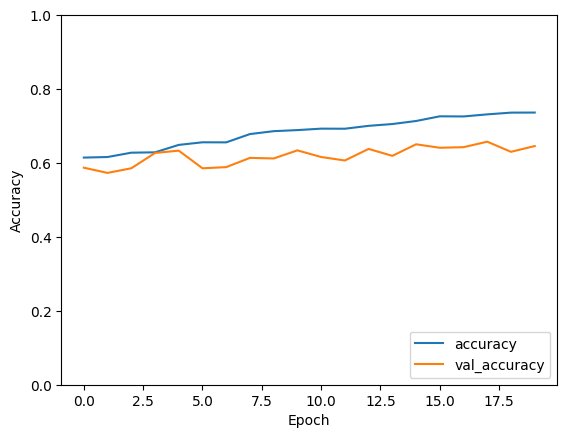

40/40 - 6s - loss: 0.8912 - accuracy: 0.6458 - 6s/epoch - 155ms/step
Test accuracy: 0.6458170413970947


In [16]:
# Plot history
plt.plot(vgg16_trained.history['accuracy'], label='accuracy')
plt.plot(vgg16_trained.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate model
vgg16_test_loss, vgg16_test_acc = custom_vgg16.evaluate(test, verbose=2)
print(f'Test accuracy: {vgg16_test_acc}')

In [17]:
# Predict
vgg16_preds = custom_vgg16.predict(test)
vgg16_ypred = np.argmax(vgg16_preds, axis=1)

# Classification report
vgg16_tdict = test.class_indices
vgg16_classes = list(vgg16_tdict.keys())
print(classification_report(test.classes, vgg16_ypred, target_names= vgg16_classes))


40/40 [==============================] - 6s 146ms/step
                  precision    recall  f1-score   support

    MildDemented       0.14      0.06      0.08       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      0.70      0.58       640
VeryMildDemented       0.38      0.26      0.31       448

        accuracy                           0.45      1279
       macro avg       0.25      0.25      0.24      1279
    weighted avg       0.40      0.45      0.41      1279



# Custom Deep Neural Network
### 3.2

In [ ]:
cnn_model = Sequential()

# Build the model
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPool2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPool2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPool2D((2, 2)))

# Flatten and add Dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))  # 4 classes for Alzheimer's stages

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)     

In [ ]:
cnn_trained = cnn_model.fit(
    train,
    epochs=10,  # Adjust as needed
    validation_data=test
)

Epoch 1/10
321/321 [==============================] - 630s 2s/step - loss: 1.0354 - accuracy: 0.5087 - val_loss: 1.1360 - val_accuracy: 0.5004
Epoch 2/10
321/321 [==============================] - 435s 1s/step - loss: 0.9108 - accuracy: 0.5579 - val_loss: 0.9633 - val_accuracy: 0.5496
Epoch 3/10
321/321 [==============================] - 406s 1s/step - loss: 0.8638 - accuracy: 0.5694 - val_loss: 0.9443 - val_accuracy: 0.5418
Epoch 4/10
321/321 [==============================] - 420s 1s/step - loss: 0.8099 - accuracy: 0.6122 - val_loss: 0.9650 - val_accuracy: 0.5324
Epoch 5/10
321/321 [==============================] - 492s 2s/step - loss: 0.7635 - accuracy: 0.6372 - val_loss: 0.9526 - val_accuracy: 0.5278
Epoch 6/10
321/321 [==============================] - 587s 2s/step - loss: 0.7071 - accuracy: 0.6657 - val_loss: 0.9434 - val_accuracy: 0.5567
Epoch 7/10
321/321 [==============================] - 638s 2s/step - loss: 0.6257 - accuracy: 0.7157 - val_loss: 1.1357 - val_accuracy: 0.5356

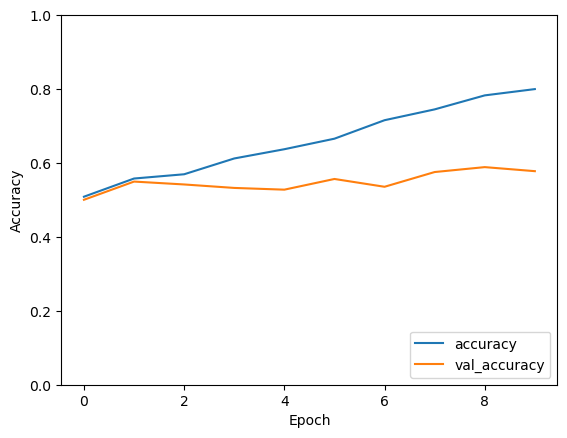

80/80 - 12s - loss: 1.3891 - accuracy: 0.5778 - 12s/epoch - 148ms/step
Test accuracy: 0.577795147895813


In [ ]:
# Plot history
plt.plot(cnn_trained.history['accuracy'], label='accuracy')
plt.plot(cnn_trained.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test, verbose=2)
print(f'Test accuracy: {cnn_test_acc}')

In [ ]:
# Predict
cnn_preds = cnn_model.predict(test)
cnn_ypred = np.argmax(cnn_preds, axis=1)

# Classification report
cnn_tdict = test.class_indices
cnn_classes = list(cnn_tdict.keys())
print(classification_report(test.classes, cnn_ypred, target_names= cnn_classes))


80/80 [==============================] - 9s 107ms/step
                  precision    recall  f1-score   support

    MildDemented       0.15      0.13      0.14       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.49      0.29      0.36       640
VeryMildDemented       0.36      0.58      0.44       448

        accuracy                           0.37      1279
       macro avg       0.25      0.25      0.24      1279
    weighted avg       0.39      0.37      0.36      1279



# Student Model - MLP
### 3.3

In [ ]:
# Initialize model
student_model = Sequential()

# Flatten image
student_model.add(Flatten(input_shape=(224, 224, 3)))

### Justification
I chose a rather simplistic model in order not to further complicate and add to the training time. I also choose it to be MLP to better demonstrate its differences from the custom deep neural network. Three layers with ReLU as the activation function are implemented, rather popularly used for being computationally efficient. For the output layer, however, instead of sigmoid, I implemented softmax instead as that is built for multiclass classification rather than binary classification.

Again, MLP is not necessarily the best for image classification, but it is chosen more so to differentiate itself from the custom deep neural network and transfer learning models.

(Ignore that it has eight layers; it was trained on four layers. I accidentally ran it twice while writing this.)

In [ ]:
# Build the model
student_model.add(Dense(512, activation='relu'))
student_model.add(Dense(256, activation='relu'))
student_model.add(Dense(128, activation='relu'))
student_model.add(Dense(4, activation='softmax'))

# Compile the model
student_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

student_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               77070848  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
 dense_10 (Dense)            (None, 512)               2560      
                                                                 
 dense_11 (Dense)            (None, 256)               1

In [ ]:
# Train the model
student_trained = student_model.fit(
    train,
    validation_data=test,
    epochs=10)

Epoch 1/10
321/321 [==============================] - 278s 861ms/step - loss: 5.1150 - accuracy: 0.4597 - val_loss: 1.2664 - val_accuracy: 0.5035
Epoch 2/10
321/321 [==============================] - 328s 1s/step - loss: 1.1948 - accuracy: 0.4917 - val_loss: 1.0360 - val_accuracy: 0.4980
Epoch 3/10
321/321 [==============================] - 351s 1s/step - loss: 1.0385 - accuracy: 0.5124 - val_loss: 1.3158 - val_accuracy: 0.5020
Epoch 4/10
321/321 [==============================] - 139s 433ms/step - loss: 0.9746 - accuracy: 0.5337 - val_loss: 1.4324 - val_accuracy: 0.5082
Epoch 5/10
321/321 [==============================] - 130s 404ms/step - loss: 0.9384 - accuracy: 0.5393 - val_loss: 1.0814 - val_accuracy: 0.5160
Epoch 6/10
321/321 [==============================] - 132s 410ms/step - loss: 0.9427 - accuracy: 0.5356 - val_loss: 1.4187 - val_accuracy: 0.5215
Epoch 7/10
321/321 [==============================] - 129s 402ms/step - loss: 0.9337 - accuracy: 0.5475 - val_loss: 1.4410 - val_a

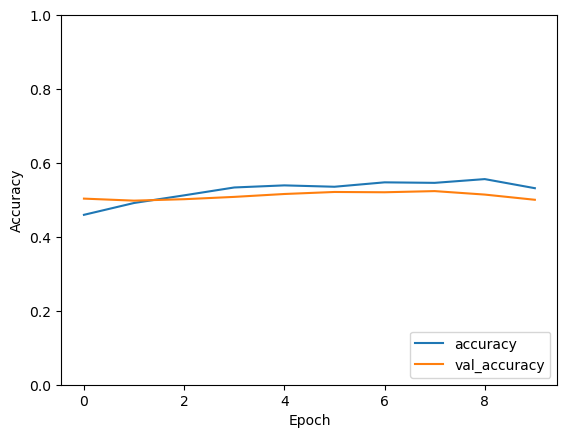

80/80 - 13s - loss: 1.5366 - accuracy: 0.5004 - 13s/epoch - 161ms/step
Test accuracy: 0.5003909468650818


In [ ]:
# Plot history
plt.plot(student_trained.history['accuracy'], label='accuracy')
plt.plot(student_trained.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate model
student_test_loss, student_test_acc = student_model.evaluate(test, verbose=2)
print(f'Test accuracy: {student_test_acc}')

In [ ]:
# Predict
stu_preds = student_model.predict(test)
stu_ypred = np.argmax(stu_preds, axis=1)

# Classification report
stu_tdict = test.class_indices
stu_classes = list(stu_tdict.keys())
print(classification_report(test.classes, stu_ypred, target_names= stu_classes))

80/80 [==============================] - 4s 44ms/step
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.50      1.00      0.67       640
VeryMildDemented       0.00      0.00      0.00       448

        accuracy                           0.50      1279
       macro avg       0.13      0.25      0.17      1279
    weighted avg       0.25      0.50      0.33      1279



C:\Users\babygirl\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\babygirl\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\babygirl\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Analysis
### #4 and #5

Out of all the models, transfer learning with a VGG16 model performed the best, according to the classification report and accuracy graphed. Perhaps because it is a model that is already optimized to learn from images that helps it perform the best as far as accuracy, followed by the custom deep neural network, a convolutional neural network which particularly perform well to process images and recognize patterns. On the other hand, MLP can still be used for such the same task, but CNNs understand spatial relationships whereas MLPs do not, hence why CNNs tended to perform better than MLP.

The only thing is that MLP is much faster compared to other models with the same number of epochs (in this case, 10). Training time, however, is arbitrary as it will only need to be trained once or few times, whereas it will be ran multiple times. As such, accuracy matters more.

Therefore, I recommend using transfer learning models, especially for those with less advanced understanding of machine learning or neural networks. For those who understand them better, they may be able to increase the accuracy of the models, and even cut training to a shorter time somehow, as they will be specifically tailored to the dataset rather than using a more general model. Though, transfer learning models may be remedied to fit the dataset better, were it to be fine-tuned. Customizing it to this dataset will reduce its generalizability, however.

Going forward, these accuracies may be better improved with further fine-tuning, more thoughtfully implemented layers, and more epochs, but for now, this provides a short demonstration of the performances of these models compared to one aother.